<a href="https://colab.research.google.com/github/MohamedElashry18/Project_deep_vision_car_detection/blob/main/Project_car__detection_NTi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/new2

/content/drive/MyDrive/new2


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="ZYgv0adUP7sqqr1D2cfh")
project = rf.workspace("dmd-test").project("dm-sys-dataset")
version = project.version(19)
dataset = version.download("yolov11")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 28.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to DM-sys-dataset-19 in yolov11:: 100%|██████████| 36542/36542 [05:37<00:00, 108.38it/s]


##train augmentation


In [ ]:
import os
import cv2
import random
import shutil
from tqdm import tqdm
import albumentations as A

train_images_dir = "/content/drive/MyDrive/new2/DM-sys-dataset-19/train/images"
train_labels_dir = "/content/drive/MyDrive/new2/DM-sys-dataset-19/train/labels"

# class id for Distracted
DISTRACTED_ID = 0

# target number of images for Distracted
TARGET_DISTRACTED_IMAGES = 4000

# 1) find all images that contain class 0 (Distracted)
distracted_labels = []

for label_file in os.listdir(train_labels_dir):
    if not label_file.endswith(".txt"):
        continue
    label_path = os.path.join(train_labels_dir, label_file)

    with open(label_path, "r") as f:
        lines = f.readlines()

    if any(line.startswith(f"{DISTRACTED_ID} ") for line in lines):
        distracted_labels.append(label_file)

print("Original # Distracted train images:", len(distracted_labels))

# 2) augmentation pipeline
transform = A.Compose(
    [
        A.RandomBrightnessContrast(p=0.5),
        A.CLAHE(p=0.3),
        A.GaussNoise(p=0.4),
        A.GaussianBlur(blur_limit=(3, 5), p=0.3),
        A.RandomGamma(p=0.3),
    ]
)

current_count = len(distracted_labels)
needed = max(0, TARGET_DISTRACTED_IMAGES - current_count)
print("Need to generate:", needed, "augmented images")

if needed > 0:
    i = 0
    pbar = tqdm(total=needed)
    while i < needed:
        label_file = random.choice(distracted_labels)
        base_name = os.path.splitext(label_file)[0]

        img_candidates = [
            base_name + ".jpg",
            base_name + ".jpeg",
            base_name + ".png"
        ]
        img_file = None
        for cand in img_candidates:
            if os.path.exists(os.path.join(train_images_dir, cand)):
                img_file = cand
                break
        if img_file is None:
            continue

        img_path = os.path.join(train_images_dir, img_file)
        label_path = os.path.join(train_labels_dir, label_file)

        image = cv2.imread(img_path)
        if image is None:
            continue

        aug = transform(image=image)
        aug_image = aug["image"]

        new_base = f"{base_name}_aug{i}"
        new_img_name = new_base + os.path.splitext(img_file)[1]
        new_lbl_name = new_base + ".txt"

        new_img_path = os.path.join(train_images_dir, new_img_name)
        new_lbl_path = os.path.join(train_labels_dir, new_lbl_name)

        cv2.imwrite(new_img_path, aug_image)
        shutil.copy(label_path, new_lbl_path)

        i += 1
        pbar.update(1)
    pbar.close()

print("Done augmentation.")


Original # Distracted train images: 1926
Need to generate: 2074 augmented images


100%|██████████| 2074/2074 [05:01<00:00,  6.87it/s]

Done augmentation.


validation


In [ ]:
import os
import cv2
import random
import shutil
from tqdm import tqdm
import albumentations as A

val_images_dir = "/content/drive/MyDrive/new2/DM-sys-dataset-19/valid/images"
val_labels_dir = "/content/drive/MyDrive/new2/DM-sys-dataset-19/valid/labels"

DISTRACTED_ID = 0
TARGET_VAL_DISTRACTED = 300

# --- Find Distracted images in validation ---
distracted_val_labels = []

for label_file in os.listdir(val_labels_dir):
    if not label_file.endswith(".txt"):
        continue

    label_path = os.path.join(val_labels_dir, label_file)

    with open(label_path, "r") as f:
        lines = f.readlines()

    if any(line.startswith(f"{DISTRACTED_ID} ") for line in lines):
        distracted_val_labels.append(label_file)

print("Original Distracted in Validation:", len(distracted_val_labels))

current = len(distracted_val_labels)
needed = TARGET_VAL_DISTRACTED - current
needed = max(needed, 0)

print("Need to generate:", needed)

# --- Light augmentation for validation ---
transform = A.Compose(
    [
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.4),
        A.GaussNoise(var_limit=(5, 15), p=0.2),
        A.GaussianBlur(blur_limit=(3, 3), p=0.2),
    ]
)

if needed > 0:
    pbar = tqdm(total=needed)
    generated = 0

    while generated < needed:
        label_file = random.choice(distracted_val_labels)
        base_name = os.path.splitext(label_file)[0]

        img_candidates = [base_name + ext for ext in [".jpg", ".jpeg", ".png"]]
        img_file = next(
            (c for c in img_candidates if os.path.exists(os.path.join(val_images_dir, c))),
            None
        )
        if img_file is None:
            continue

        img_path = os.path.join(val_images_dir, img_file)
        image = cv2.imread(img_path)

        if image is None:
            continue

        # Apply light augmentation
        aug = transform(image=image)
        aug_image = aug["image"]

        new_base = f"{base_name}_aug_val{generated}"
        new_img_name = new_base + os.path.splitext(img_file)[1]
        new_lbl_name = new_base + ".txt"

        cv2.imwrite(os.path.join(val_images_dir, new_img_name), aug_image)
        shutil.copy(
            os.path.join(val_labels_dir, label_file),
            os.path.join(val_labels_dir, new_lbl_name)
        )

        generated += 1
        pbar.update(1)

    pbar.close()

print("Validation augmentation completed!")


/tmp/ipython-input-534739147.py:41: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5, 15), p=0.2),


Original Distracted in Validation: 32
Need to generate: 268


100%|██████████| 268/268 [00:27<00:00,  9.62it/s]

Validation augmentation completed!


In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.3/112.6 GB disk)


In [ ]:
from ultralytics import YOLO

# Load a pretrained model (nano version for speed)
model = YOLO("yolo11n.pt")

In [ ]:
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_

In [ ]:
results = model.train(
    data="/content/drive/MyDrive/new2/DM-sys-dataset-19/data.yaml",  # path to dataset YAML
    epochs=10,                 # number of epochs
    imgsz=320,                 # image size
    batch=32,                  # batch size

    project="/content/drive/MyDrive/new2/results",     # where to save results
    name="exp1",               # experiment name
    device="0"                 # use GPU 0 (or "cpu")
)

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/new2/DM-sys-dataset-19/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=

In [ ]:
model = YOLO("/content/drive/MyDrive/new2/results/exp1/weights/best.pt")
# Fine-tune on your dataset
results = model.train(
    data="/content/drive/MyDrive/new2/DM-sys-dataset-19/data.yaml",  # path to dataset YAML
    epochs=50,                 # number of epochs
    imgsz=320,                 # image size
    batch=16,                  # batch size
    project="/content/drive/MyDrive/new2/results",     # where to save results
    name="exp2",               # experiment name
    device="0"                 # use GPU 0 (or "cpu")
)

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/new2/DM-sys-dataset-19/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/new2/results/exp1/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto,

In [ ]:
for key , value in results.results_dict.items():
  print(f"{key} : {value}")


metrics/precision(B) : 0.9494959811021781
metrics/recall(B) : 0.8780233721518901
metrics/mAP50(B) : 0.9484274357210674
metrics/mAP50-95(B) : 0.7185733418596556
fitness : 0.7185733418596556


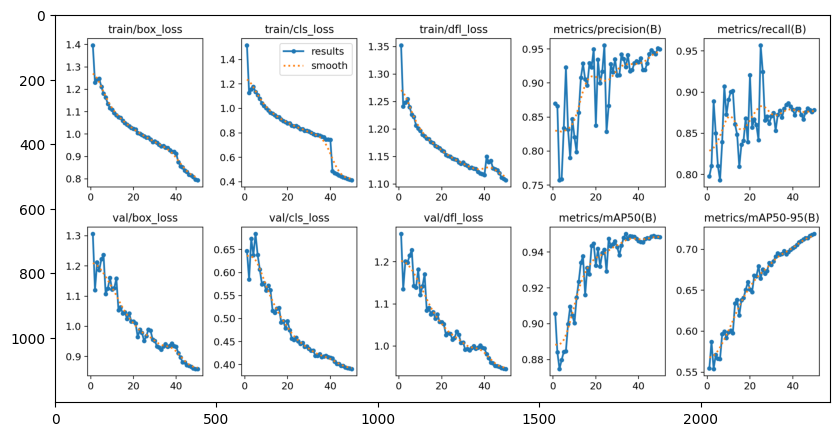

In [ ]:
import matplotlib.pyplot as plt
img = plt.imread("/content/drive/MyDrive/new2/results/exp2/results.png")
plt.figure(figsize=(10,10))
plt.imshow(img)

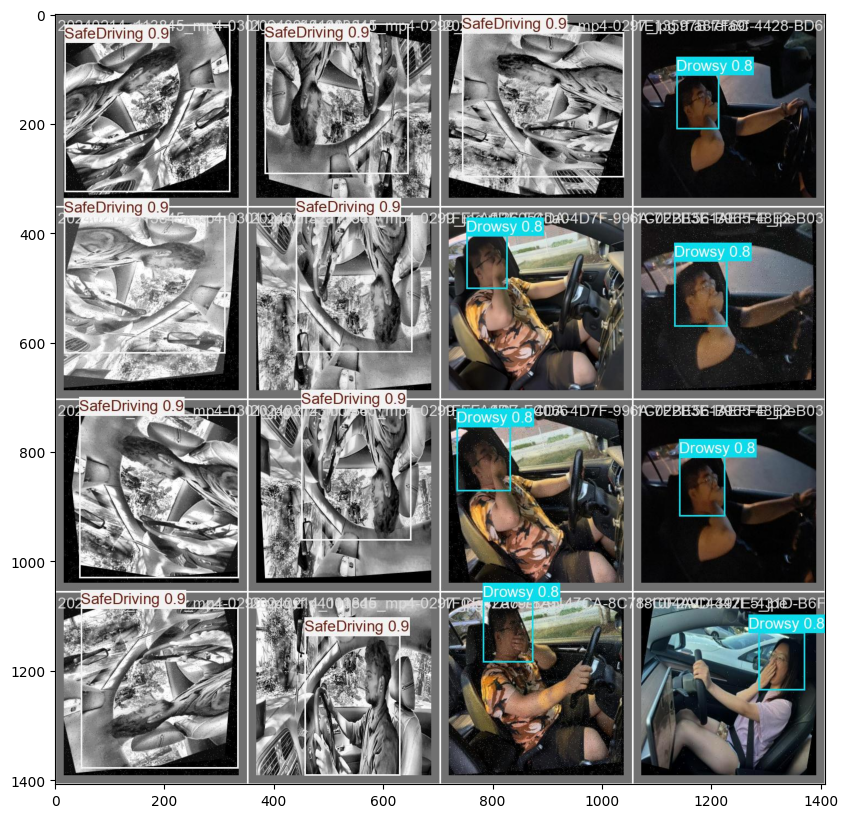

In [ ]:
img = plt.imread("/content/drive/MyDrive/new2/results/exp2/val_batch1_pred.jpg")
plt.figure(figsize=(10,10))
plt.imshow(img)

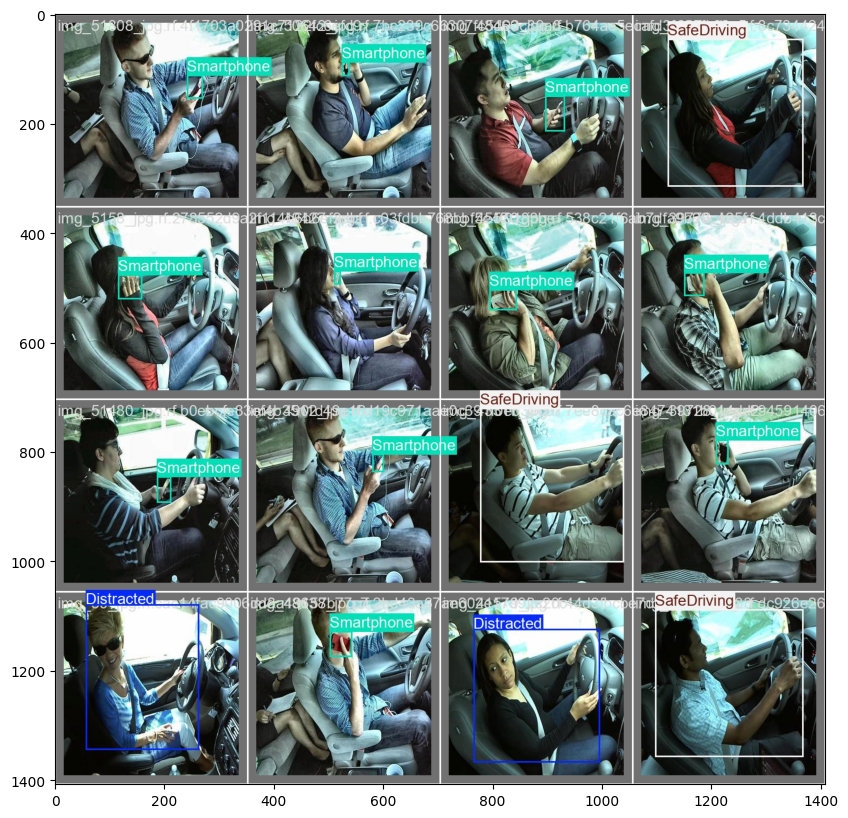

In [ ]:
import matplotlib.pyplot as plt
img = plt.imread("/content/drive/MyDrive/new2/results/exp2/val_batch0_labels.jpg")
plt.figure(figsize=(10,10))
plt.imshow(img)

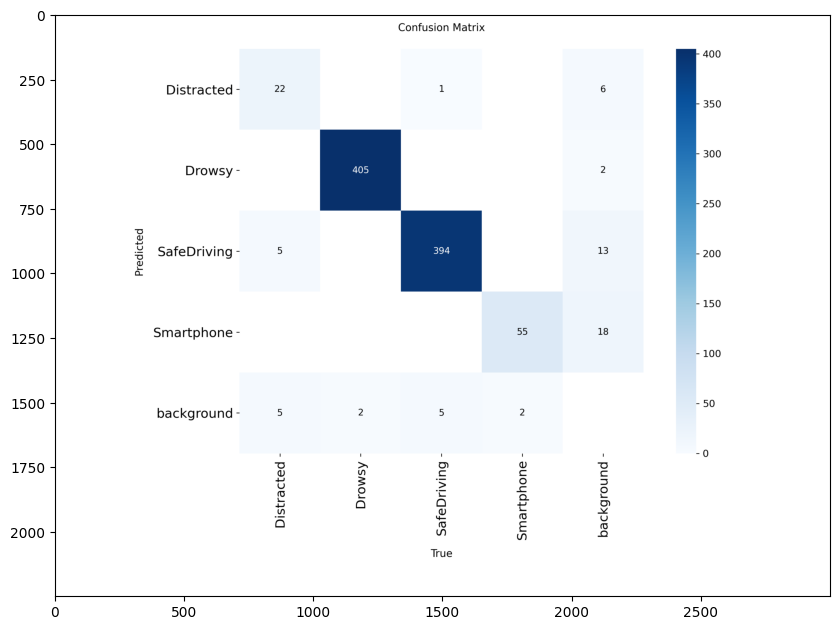

In [ ]:
img = plt.imread("/content/drive/MyDrive/new2/results/exp2/confusion_matrix.png")
plt.figure(figsize=(10,10))
plt.imshow(img)

In [ ]:
valid_result = model.val()

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.6±0.3 ms, read: 11.2±4.7 MB/s, size: 21.8 KB)
val: Scanning /content/drive/MyDrive/new2/DM-sys-dataset-19/valid/labels.cache... 917 images, 25 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 917/917 1.3Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 58/58 4.9it/s 11.9s
                   all        917        896      0.949      0.878      0.948      0.718
            Distracted         32         32      0.931      0.594      0.841       0.61
                Drowsy        407        407      0.989       0.99      0.993      0.753
           SafeDriving        400        400      0.968      0.981      0.994      0.866
            Smartphone         57         57      0.909      0.947      0.966      0.642
Speed: 0.5ms preproc

In [ ]:
print(valid_result.box.map)  # map50-95
print(valid_result.box.map50)  # map50
print(valid_result.box.map75)  # map75
print(valid_result.box.maps)  # a list contains map50-95 of each category

0.7179242391591611
0.9483983383156511
0.8746573835118603
[    0.60999     0.75338     0.86594     0.64238]


In [ ]:
results = model.predict("/content/0B03D785-CCF6-4202-82AA-117339CE271C_jpeg_jpg.rf.d19bdca55ea22dbcea44f40aa37bb3de.jpg", save=True, imgsz=640)



image 1/1 /content/0B03D785-CCF6-4202-82AA-117339CE271C_jpeg_jpg.rf.d19bdca55ea22dbcea44f40aa37bb3de.jpg: 640x640 1 Drowsy, 10.3ms
Speed: 2.6ms preprocess, 10.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/drive/MyDrive/new2/runs/detect/predict
